In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
import torch
import torch.nn as nn
import dtnnlib as dtnn

In [2]:
num_points = 75
# X1 = np.linspace(-2.5, 1.9, num_points)
X1 = np.linspace(-2.5, 2.5, num_points)
X2 = np.linspace(-2.5, 3, num_points)
# X2 = np.linspace(-2.2, 2.1, num_points)
X1, X2 = np.meshgrid(X1, X2)

Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)
# Y = np.sqrt(X1**2 + X2**2)

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

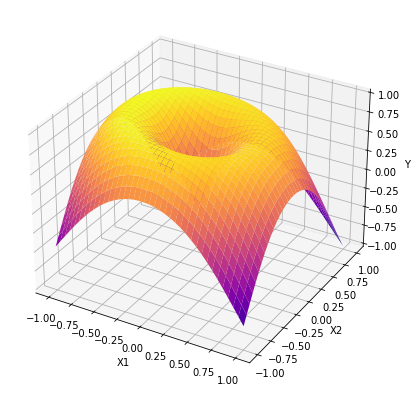

In [7]:
x1 = X1.reshape(-1)
x2 = X2.reshape(-1)
y = Y.reshape(-1)

xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)
xx, yy = torch.FloatTensor(xx), torch.FloatTensor(yy)


%matplotlib inline
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [160]:
## Define piecewise MLP
torch.manual_seed(103)

h = 8
net = nn.Sequential(
            nn.Linear(2, h),
            nn.ReLU(),
            nn.Linear(h, 1),
)

In [161]:
device = torch.device("cuda:0")

In [162]:
xx, yy = xx.to(device), yy.to(device)
net.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=1, bias=True)
)

In [163]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [164]:
# fig = plt.figure(figsize=(9,8))
# ax = plt.axes(projection='3d')

for epoch in range(5000):

    yout = net(xx)
    loss =criterion(yout, yy)
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()
    
    if epoch%200 == 0:
        error = float(loss)
        print(f'Epoch:{epoch} | Error:{error}')
#         ax.clear()
        
#         ax.scatter(X1, X2, Y)
#         yout_ = yout.reshape(Y.shape)
#         ax.scatter(X1, X2, yout_, color='r', marker='.')
#         ax.set_xlabel('X1')
#         ax.set_ylabel('X2')
#         ax.set_zlabel('Y')
        
#         fig.canvas.draw()
#         plt.pause(0.01)

Epoch:0 | Error:1.074070930480957
Epoch:200 | Error:0.2515735328197479
Epoch:400 | Error:0.13053618371486664
Epoch:600 | Error:0.1143478974699974
Epoch:800 | Error:0.10312843322753906
Epoch:1000 | Error:0.09313519299030304
Epoch:1200 | Error:0.08480628579854965
Epoch:1400 | Error:0.07833268493413925
Epoch:1600 | Error:0.07308680564165115
Epoch:1800 | Error:0.06815246492624283
Epoch:2000 | Error:0.06304515153169632
Epoch:2200 | Error:0.05752318724989891
Epoch:2400 | Error:0.05170047655701637
Epoch:2600 | Error:0.046160124242305756
Epoch:2800 | Error:0.04116588085889816
Epoch:3000 | Error:0.03676963597536087
Epoch:3200 | Error:0.03302221745252609
Epoch:3400 | Error:0.029922466725111008
Epoch:3600 | Error:0.02748248539865017
Epoch:3800 | Error:0.02554444968700409
Epoch:4000 | Error:0.02377496287226677
Epoch:4200 | Error:0.022325808182358742
Epoch:4400 | Error:0.02124940976500511
Epoch:4600 | Error:0.020375700667500496
Epoch:4800 | Error:0.01961134374141693


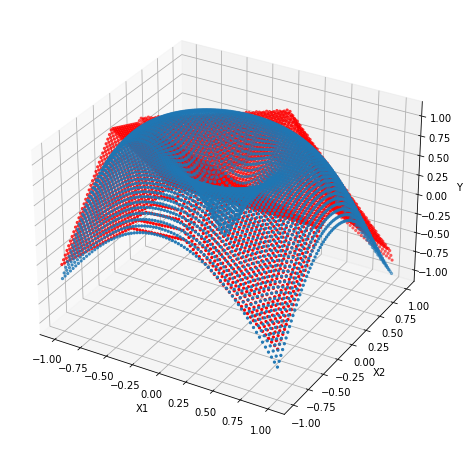

In [165]:
%matplotlib inline

yout_ = yout.data.cpu().reshape(Y.shape)

fig = plt.figure(figsize=(9,8))
ax = plt.axes(projection='3d')
ax.scatter(X1, X2, Y, marker= '.')
ax.scatter(X1, X2, yout_, color='r', marker='.')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [166]:
### Extracting the pieces
###### equation of line where (wx+b) == 0

## (x0w0 + x1w1 + b = 0) ... solving
## x2 = (-b-w1x1)/w2

## lets draw line given x1 is in -2 and 2.
lines = []
vecs = []
for i in range(len(net[0].bias)):
    ## for x1 = -2 and 2
    with torch.no_grad():
        w1, w2 = net[0].weight.t()[:, i]
        x2_a = -(net[0].bias[i]+w1*-2)/w2
        x2_b = -(net[0].bias[i]+w1*2)/w2
#         lines.append([(-2, x2_a), (2, x2_b)])
        lines.append([(-1, x2_a), (1, x2_b)])
        
        vecs.append([w1, w2])

In [167]:
lines = torch.Tensor(lines).cpu().numpy()
vecs = torch.Tensor(vecs).cpu().numpy()
lines

array([[[-1.        ,  1.75771   ],
        [ 1.        ,  0.63835096]],

       [[-1.        ,  1.8485086 ],
        [ 1.        ,  0.59838164]],

       [[-1.        ,  0.44774362],
        [ 1.        , -0.59115297]],

       [[-1.        ,  2.748914  ],
        [ 1.        , -1.0985548 ]],

       [[-1.        ,  0.4648342 ],
        [ 1.        , -2.2347748 ]],

       [[-1.        ,  4.6583    ],
        [ 1.        , -0.39959607]],

       [[-1.        , -0.0902527 ],
        [ 1.        ,  1.2769343 ]],

       [[-1.        , -1.8328242 ],
        [ 1.        ,  0.1646644 ]]], dtype=float32)

In [191]:
## make lines with max norm of 1
lines = lines.reshape(-1, 2)
lines = lines/np.linalg.norm(lines, axis=1, keepdims=True)*2
lines = lines.reshape(-1, 2,2)

In [192]:
vecs = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)

In [193]:
## interpolation of points along the lines
interp = np.linspace(0, 1, 20)
interp.shape, lines.shape

((20,), (8, 2, 2))

In [194]:
interp = interp.reshape(-1,1)

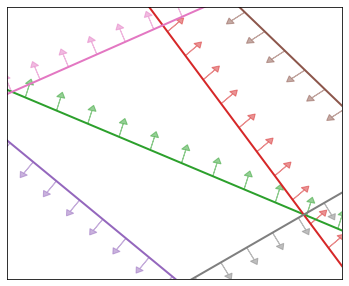

In [295]:
## plot the lines
plt.figure(figsize=(6,5))
for i, line in enumerate(lines):
    color = matplotlib.cm.tab10(i)
    plt.plot(line[:,0], line[:,1], c=color, lw=2)
#     plt.arrow(0, 0, vecs[i][0]/4, vecs[i][1]/4, head_width=0.05, head_length=0.04, fc=color, ec=color, linestyle='solid', alpha=0.5)
    
    pts = lines[i,0]*interp + lines[i,1]*(1-interp)
    for j in range(len(pts)): 
        plt.arrow(pts[j,0], pts[j,1], vecs[i][0]/10, vecs[i][1]/10, head_width=0.05, head_length=0.04, fc=color, ec=color, linestyle='solid', alpha=0.5)
    
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.savefig("./outputs/01.3_linear_neurons_2d.pdf", bbox_inches='tight')

In [54]:
xx.min(dim=0)[0], xx.max(dim=0)[0]

(tensor([-1., -1.], device='cuda:0'), tensor([1., 1.], device='cuda:0'))

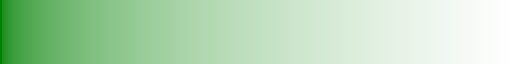

In [139]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("cust0", ['green', 'white'], gamma=0.4)
my_cmap

## Visualize Radial Neurons

In [172]:
import dtnnlib as dtnn

In [239]:
## Define piecewise MLP
torch.manual_seed(103)

h = 8
net = nn.Sequential(
            dtnn.DistanceTransform_MinExp(2, h),
            nn.Sequential(
                dtnn.ScaleShift(h),
                dtnn.OneActiv(h, mode="exp_1.6"),
            ),
            nn.Linear(h, 1),
)

In [240]:
device = torch.device("cuda:0")

In [241]:
xx, yy = xx.to(device), yy.to(device)
net.to(device)

Sequential(
  (0): DistanceTransform_MinExp()
  (1): Sequential(
    (0): ScaleShift()
    (1): OneActiv()
  )
  (2): Linear(in_features=8, out_features=1, bias=True)
)

In [242]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [244]:
for epoch in range(5000):

    yout = net(xx)
    loss =criterion(yout, yy)
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()
    
    if epoch%200 == 0:
        error = float(loss)
        print(f'Epoch:{epoch} | Error:{error}')

Epoch:0 | Error:0.01984298788011074
Epoch:200 | Error:0.019742125645279884
Epoch:400 | Error:0.01965572126209736
Epoch:600 | Error:0.019564347341656685
Epoch:800 | Error:0.019262250512838364
Epoch:1000 | Error:0.01916295662522316
Epoch:1200 | Error:0.0190774854272604
Epoch:1400 | Error:0.0189962238073349
Epoch:1600 | Error:0.018916435539722443
Epoch:1800 | Error:0.01884012669324875
Epoch:2000 | Error:0.0187656469643116
Epoch:2200 | Error:0.018690962344408035
Epoch:2400 | Error:0.018617747351527214
Epoch:2600 | Error:0.018546832725405693
Epoch:2800 | Error:0.018481435254216194
Epoch:3000 | Error:0.018416743725538254
Epoch:3200 | Error:0.018355904147028923
Epoch:3400 | Error:0.018302876502275467
Epoch:3600 | Error:0.018249867483973503
Epoch:3800 | Error:0.018200065940618515
Epoch:4000 | Error:0.018155423924326897
Epoch:4200 | Error:0.018108079209923744
Epoch:4400 | Error:0.018065670505166054
Epoch:4600 | Error:0.01802513189613819
Epoch:4800 | Error:0.017983490601181984


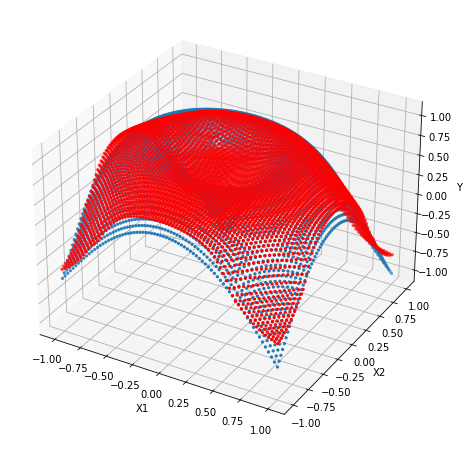

In [245]:
%matplotlib inline

yout_ = yout.data.cpu().reshape(Y.shape)

fig = plt.figure(figsize=(9,8))
ax = plt.axes(projection='3d')
ax.scatter(X1, X2, Y, marker= '.')
ax.scatter(X1, X2, yout_, color='r', marker='.')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [246]:
centers = net[0].centers.data.cpu()
centers

tensor([[-0.2983,  0.2236],
        [-0.4563,  0.4101],
        [-0.9487,  1.2521],
        [-0.2202,  0.1595],
        [ 1.1029,  1.9112],
        [-0.4619,  0.4152],
        [-1.9302, -1.1967],
        [ 1.8126, -1.8132]])

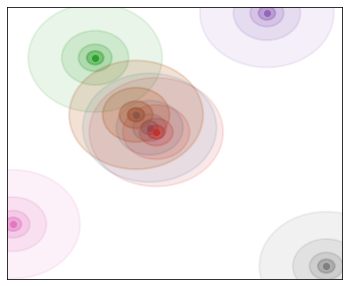

In [296]:
fig = plt.figure(figsize=(9,8))
ax = fig.gca()
for i, cent in enumerate(centers):
    color = matplotlib.cm.tab10(i)
#     print(cent)
    alpha = 0.4
    for scale in [2, 4, 8, 16]:
        ell = matplotlib.patches.Ellipse(cent, scale*0.1, scale*0.1, 180., edgecolor=color, facecolor=color, lw=2)
#             ell.set_clip_box(ax.bbox)
        ell.set_alpha(alpha/np.log2(scale))
        ax.add_artist(ell)
        pass
    plt.scatter(cent[0], cent[1], color=color)
#     pts = lines[i,0]*interp + lines[i,1]*(1-interp)
#     for j in range(len(pts)): 
#         plt.arrow(pts[j,0], pts[j,1], vecs[i][0]/10, vecs[i][1]/10, head_width=0.05, head_length=0.04, fc=color, ec=color, linestyle='solid', alpha=0.5)
    
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)

In [267]:
actf = net[0](xx).data.cpu()

In [301]:
# index = np.random.randint(len(actf))
# index

128

In [ ]:
# index = 3660, 603, 5012, 4993

In [289]:
actf[index]

tensor([0.8335, 0.5481, 0.0769, 1.0000, 0.1147, 0.5395, 0.0042, 0.0167])

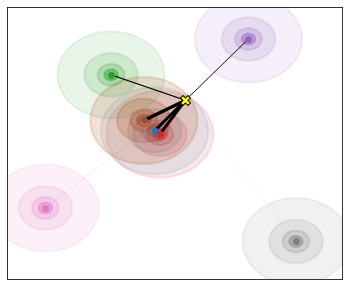

In [341]:
fig = plt.figure(figsize=(6,5))
ax = fig.gca()
alpha = 0.4

# index = np.random.randint(len(actf))
_x0, _x1 = xx[index][0].item(), xx[index][1].item()

for i, cent in enumerate(centers):
    color = matplotlib.cm.tab10(i)
    for scale in [2, 4, 8, 16]:
        ell = matplotlib.patches.Ellipse(cent, scale*0.1, scale*0.1, 180., edgecolor=color, facecolor=color, lw=2)
#             ell.set_clip_box(ax.bbox)
        ell.set_alpha(alpha/np.log2(scale))
        ax.add_artist(ell)
        pass
    
    plt.plot([cent[0], _x0], [cent[1], _x1], lw=actf[index][i].item()*3, color='k', zorder=10)
    plt.scatter(cent[0], cent[1], color=color, zorder=100)
    pass
plt.scatter(_x0, _x1, edgecolors='k', facecolors='yellow', s=100, lw=1, marker='X', zorder=99)

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.savefig("./outputs/01.3_distminexp_neurons_2d.pdf", bbox_inches='tight')

In [337]:
index

4993